In [25]:
from muler.igrins import IGRINSSpectrum
from muler.hpf import HPFSpectrum

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import glob
import os
import warnings

import astropy.units as u
# from astropy.io import ascii
# from astropy.io import fits
# from astropy.table import Table, Column, join
# from astropy.wcs import WCS
from astropy.modeling import models, fitting

from specutils import Spectrum1D
from specutils import SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum, fit_lines
from specutils.analysis import equivalent_width

%matplotlib inline
%config InlineBackend.figure_format='retina'
%config Completer.use_jedi = False

In [26]:
# path = 'A:/Documents/Grad_School/Research/igrins_reduced/20161101/'
# filename = 'SDCK_20161101_0062.spec_a0v.fits'
# spec = IGRINSSpectrum(file=path+filename)

# Reduced data in txt files
data_path = "A:/Documents/Grad_School/Research/IGRINS_Merged/"
# File path for figures to live in
fig_path = "A:/Documents/Grad_School/IGRINS-Spectra/IGRINS_figs/standards_spectra/"

# Create the folder if it doesn't exist
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

# Nicole's merged K-band spectra of some Taurus Standards
merged_standard_files = glob.glob(data_path+"merged_standards/m*.txt")

# NIR Lines in micron
nir_dict = {
    "Fe-2.084": 2.084,
    "Si-2.092"	:	2.092,
    "Mg-2.106"	:	2.106,
    "Al-2.11"	:	2.11,
    "Ca-2.2035"	:	2.2035,
    "Fe-2.2037"	:	2.2037,
    "Sc-2.2052"	:	2.2052,
    "Na-2.2052"	:	2.2052,
    "Si-2.2063"	:	2.2063,
    "Sc-2.2065"	:	2.2065,
    "Si-2.2073"	:	2.2073,
    "Fe-2.2079"	:	2.2079,
    "Na-2.2083"	:	2.2083,
    "Ca-2.2113"	:	2.2113,
    "Br-Gamma"  :   2.1655,
    "Ti-2.2218"	:	2.2218,
    "Ti-2.224"	:	2.224,
    "Fe-2.226"	:	2.226,
    "Ti-2.228"	:	2.228,
    "Ti-2.232"	:	2.232,
    "Ca-2.26573"	:	2.26573,
    "Fe-2.2742"	:	2.2742,
    "Mg-2.281"	:	2.281,
    "Ca-2.2825"	:	2.2825,
    "Fe-2.284"	:	2.284,
    "Ti-2.29"	:	2.29,
    "Ti-2.297"	:	2.297
}
    # "CO(2-0)-2.29353" :	2.29353,
    # "CO(2-0)-2.32265"	:	2.32265,
    # "CO(2-0)-2.34327" :	2.34327,
    # "CO(2-0)-2.34531" :	2.34531,
    # "CO(2-0)-2.3495" 	:	2.3495,
    # "CO(2-0)-2.35167"	:	2.35167,
    # "CO(2-0)-2.35246" :	2.35246,
    # "CO(2-0)-2.38295" :	2.38295,
    # }

# Strings of the Nir lines
lines_str = list(nir_dict.keys())

# Wavelength values for each NIR line
lines_wav = list(nir_dict.values())

In [27]:
# Plotting Parameters
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] =18
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.major.size'] = 7
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.direction'] = 'in'

In [28]:
# Pandas Column IDs
igrins_cols = ['Wavelength', 'Flux', 'SNR','zero']

# Anon 1
anon1_df = pd.read_csv(merged_standard_files[0], delimiter='\s+', comment='#', names = igrins_cols)
# SNR column is an object for some reason, change to float
anon1_df['SNR'] = anon1_df['SNR'].astype(float)

# No negative flux and require SNR > 5
#  & (anon1_df['SNR'] < 10000)
anon1_df = anon1_df[(anon1_df['Flux'] > 0.4e6) & (anon1_df['SNR'] > 5) & (anon1_df['SNR'] < 10000)] 

# Wavelength + Flux Arrays
anon1_wavlen = anon1_df['Wavelength']
anon1_flux = anon1_df['Flux']

# Try to do some continuum fitting
Want to fit a local continuum to get equivalent widths

In [29]:
# Make 1D Spectrum Object
anon1_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_flux.values*u.ct)

reg_select = anon1_spec.spectral_axis
# anon1_spec[]

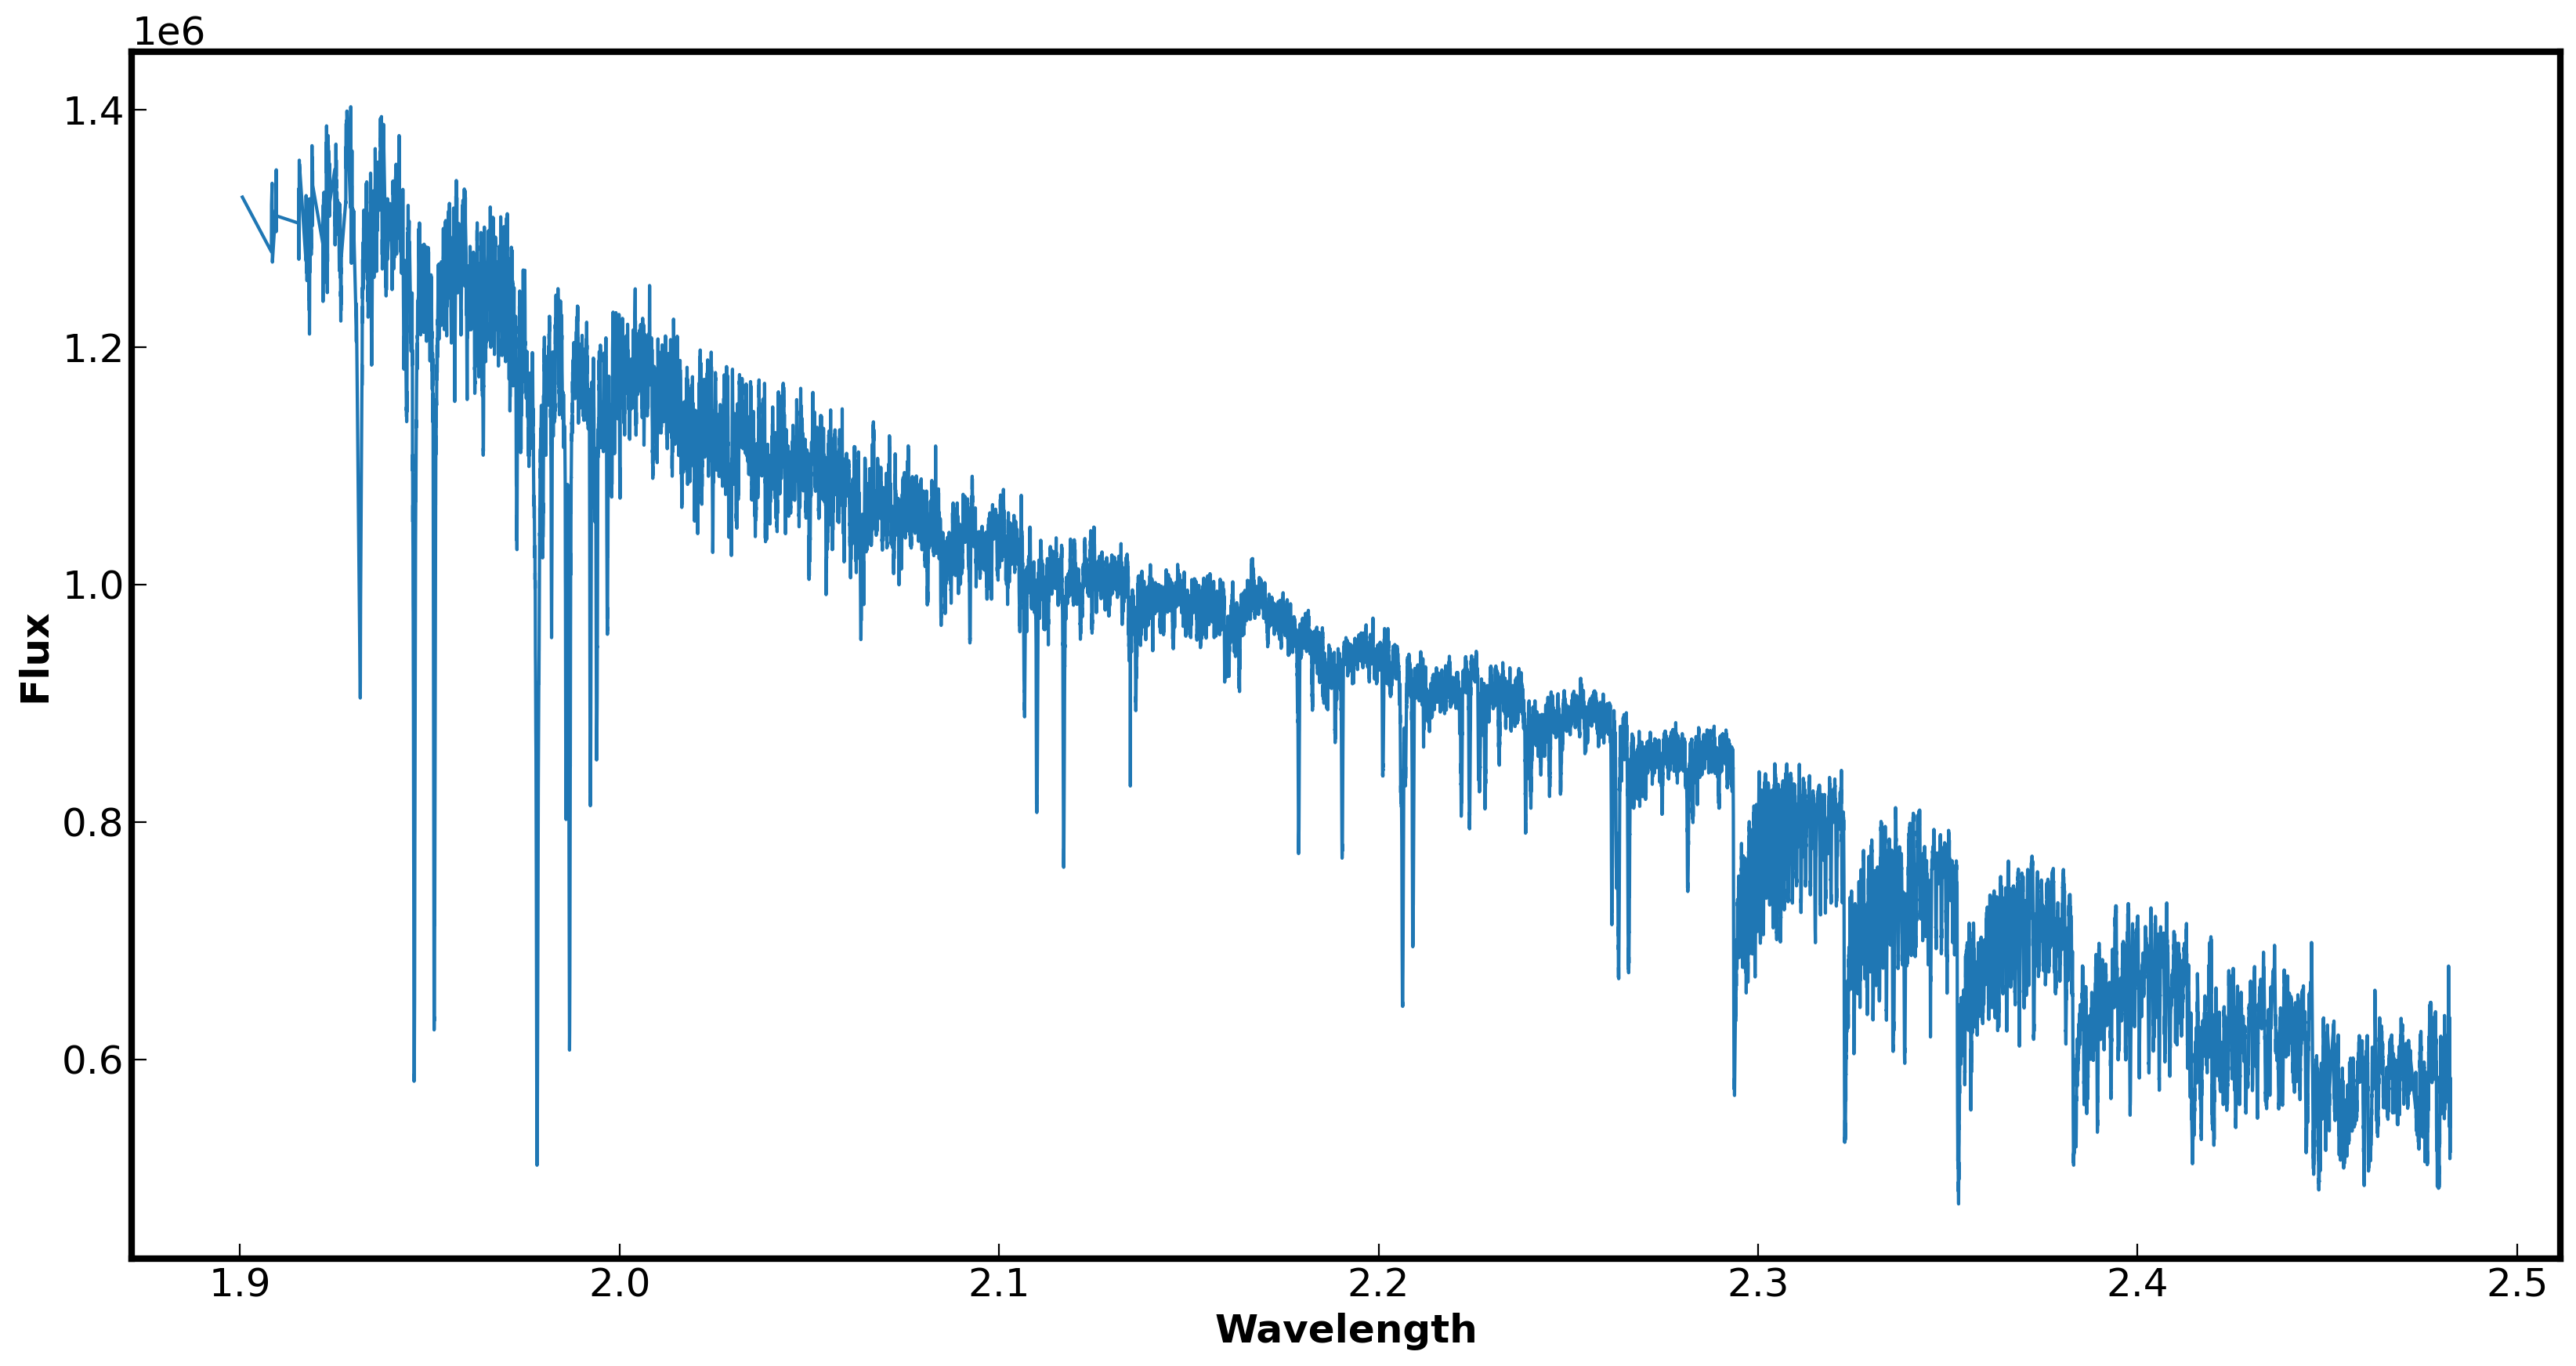

In [30]:
fig,ax = plt.subplots(figsize=(20,10))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux)
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.show()

In [31]:
# Define spectral region of interest
region = (2.22,2.235)*u.um
region_mask = (anon1_spec.spectral_axis >= region[0]) & (anon1_spec.spectral_axis <= region[1])


with warnings.catch_warnings():  # Ignore warnings
    warnings.simplefilter('ignore')
    cont_fit = fit_continuum(anon1_spec)


continuum_fitted = cont_fit(anon1_spec.spectral_axis)

anon1_norm_flux = anon1_spec.flux/continuum_fitted

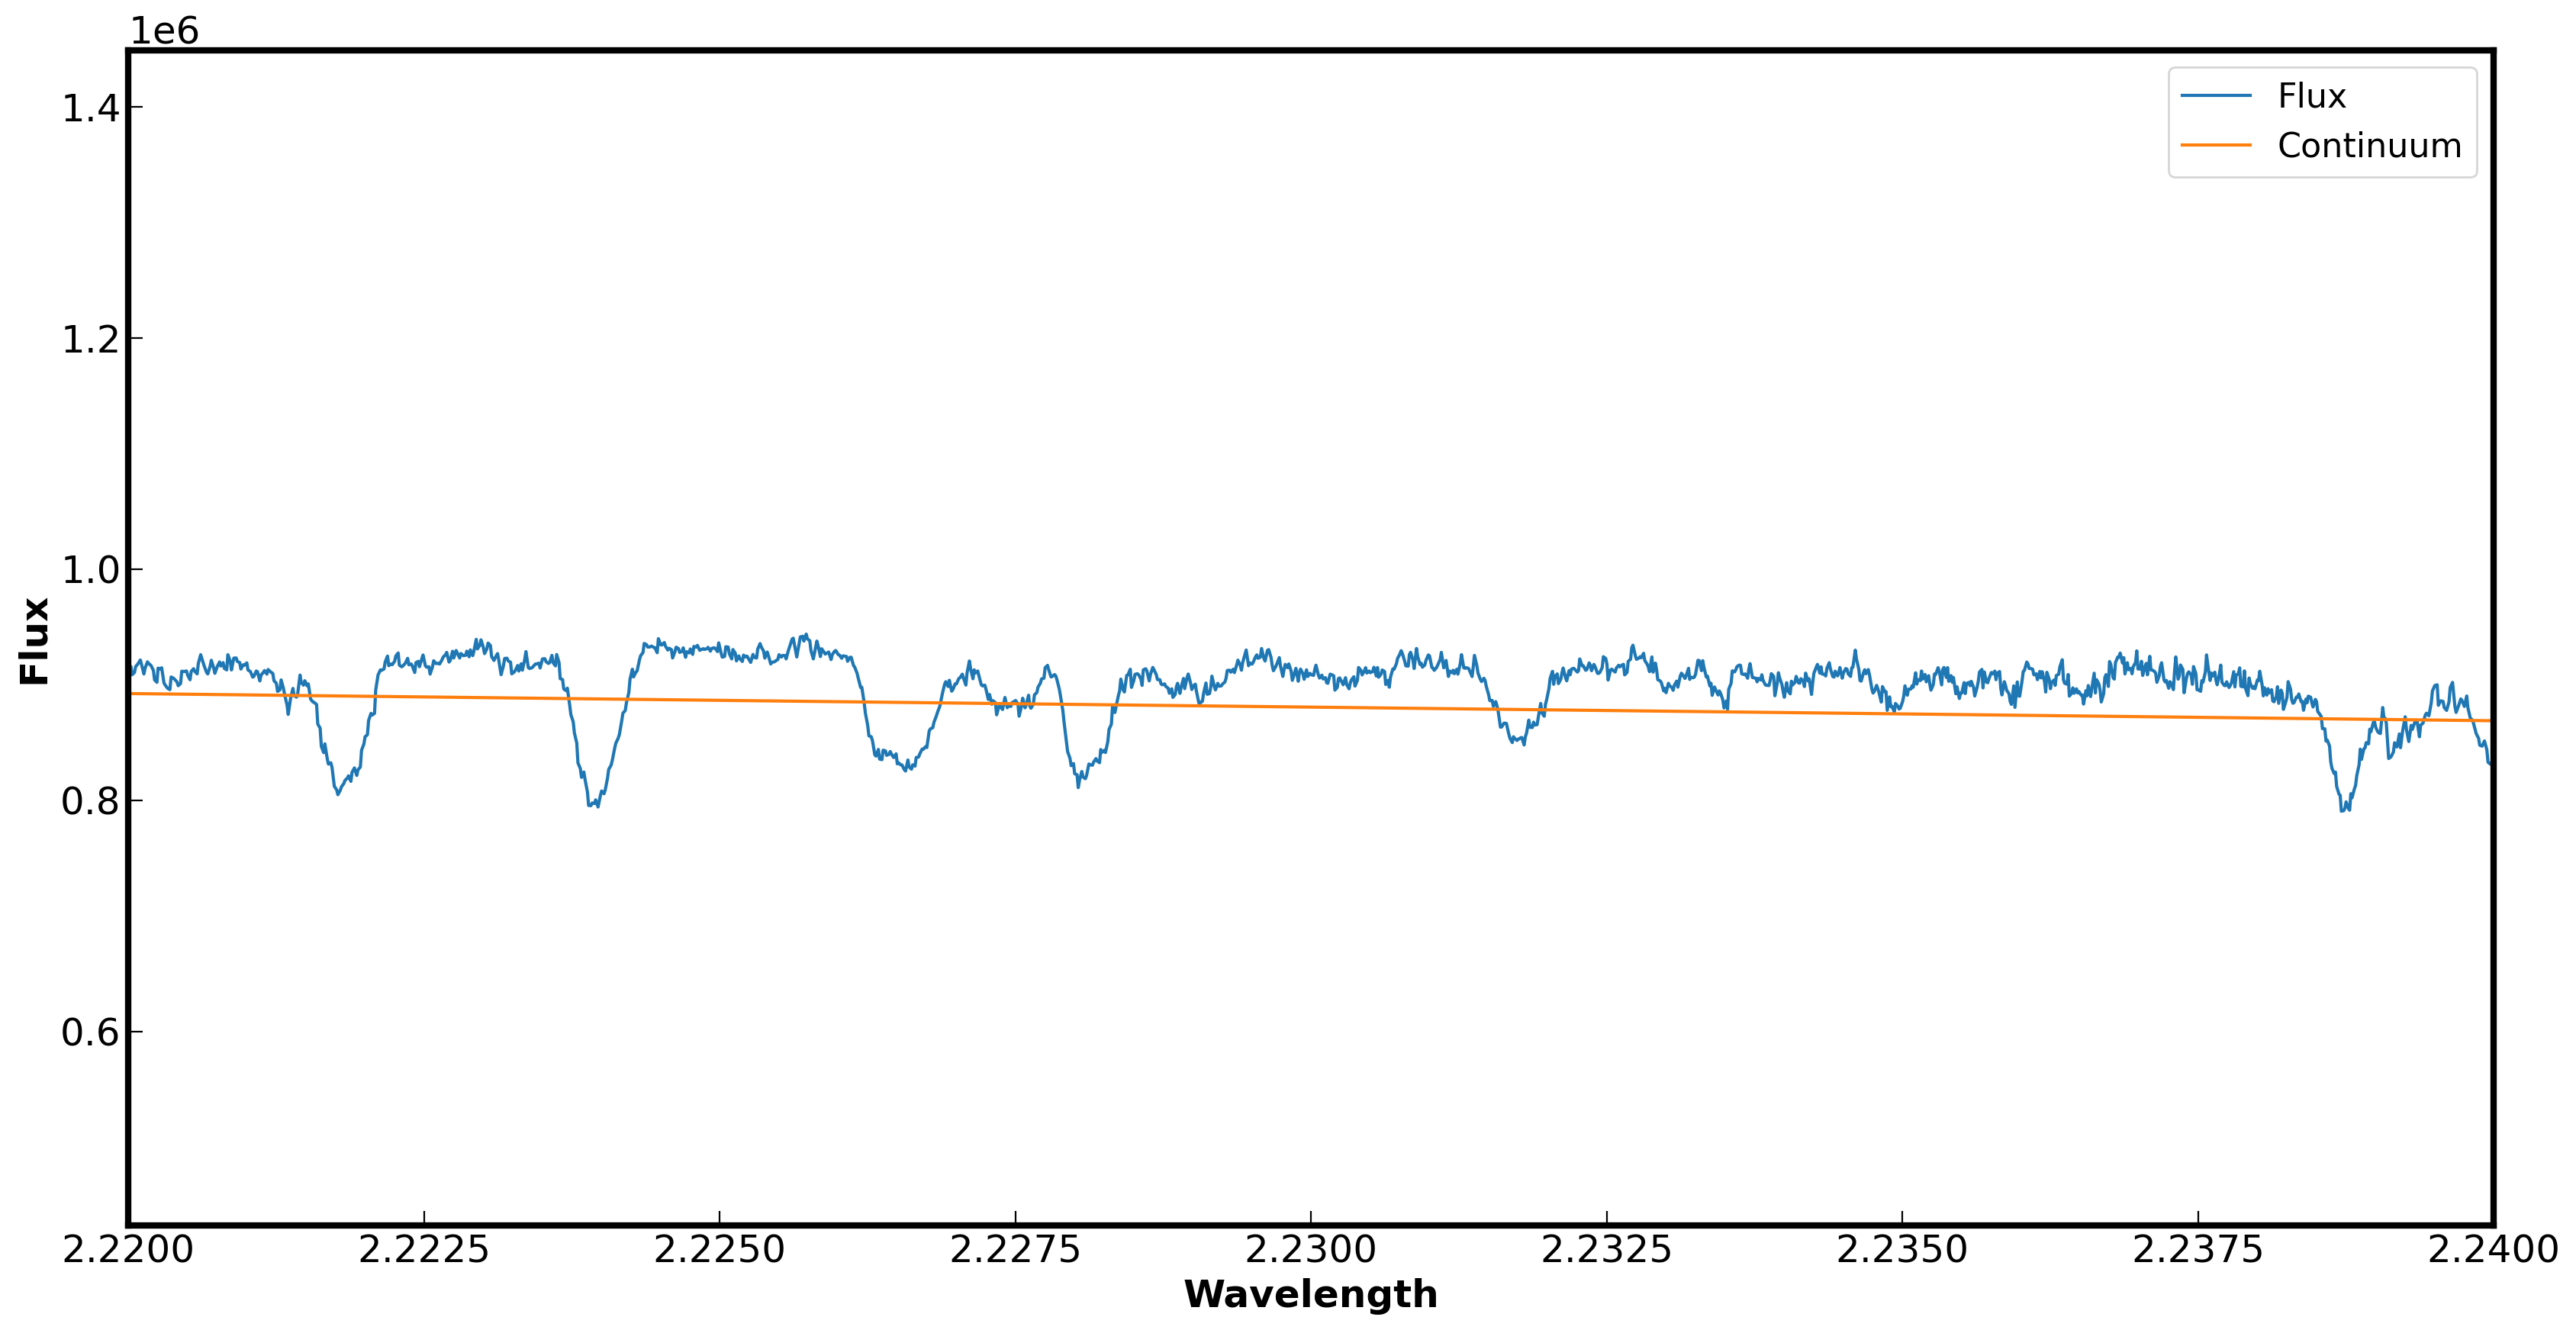

In [60]:
# Make 1D Spectrum Object
anon1_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_flux.values*u.ct)

fig,ax = plt.subplots(figsize=(20,10))

plt.plot(anon1_spec.spectral_axis, anon1_spec.flux,label='Flux')
plt.plot(anon1_spec.spectral_axis,continuum_fitted,label='Continuum')

ax.set_xlim(2.22,2.24)
# ax.set_ylim(0.8,1.1)

# ax.set_yscale('log')
plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()

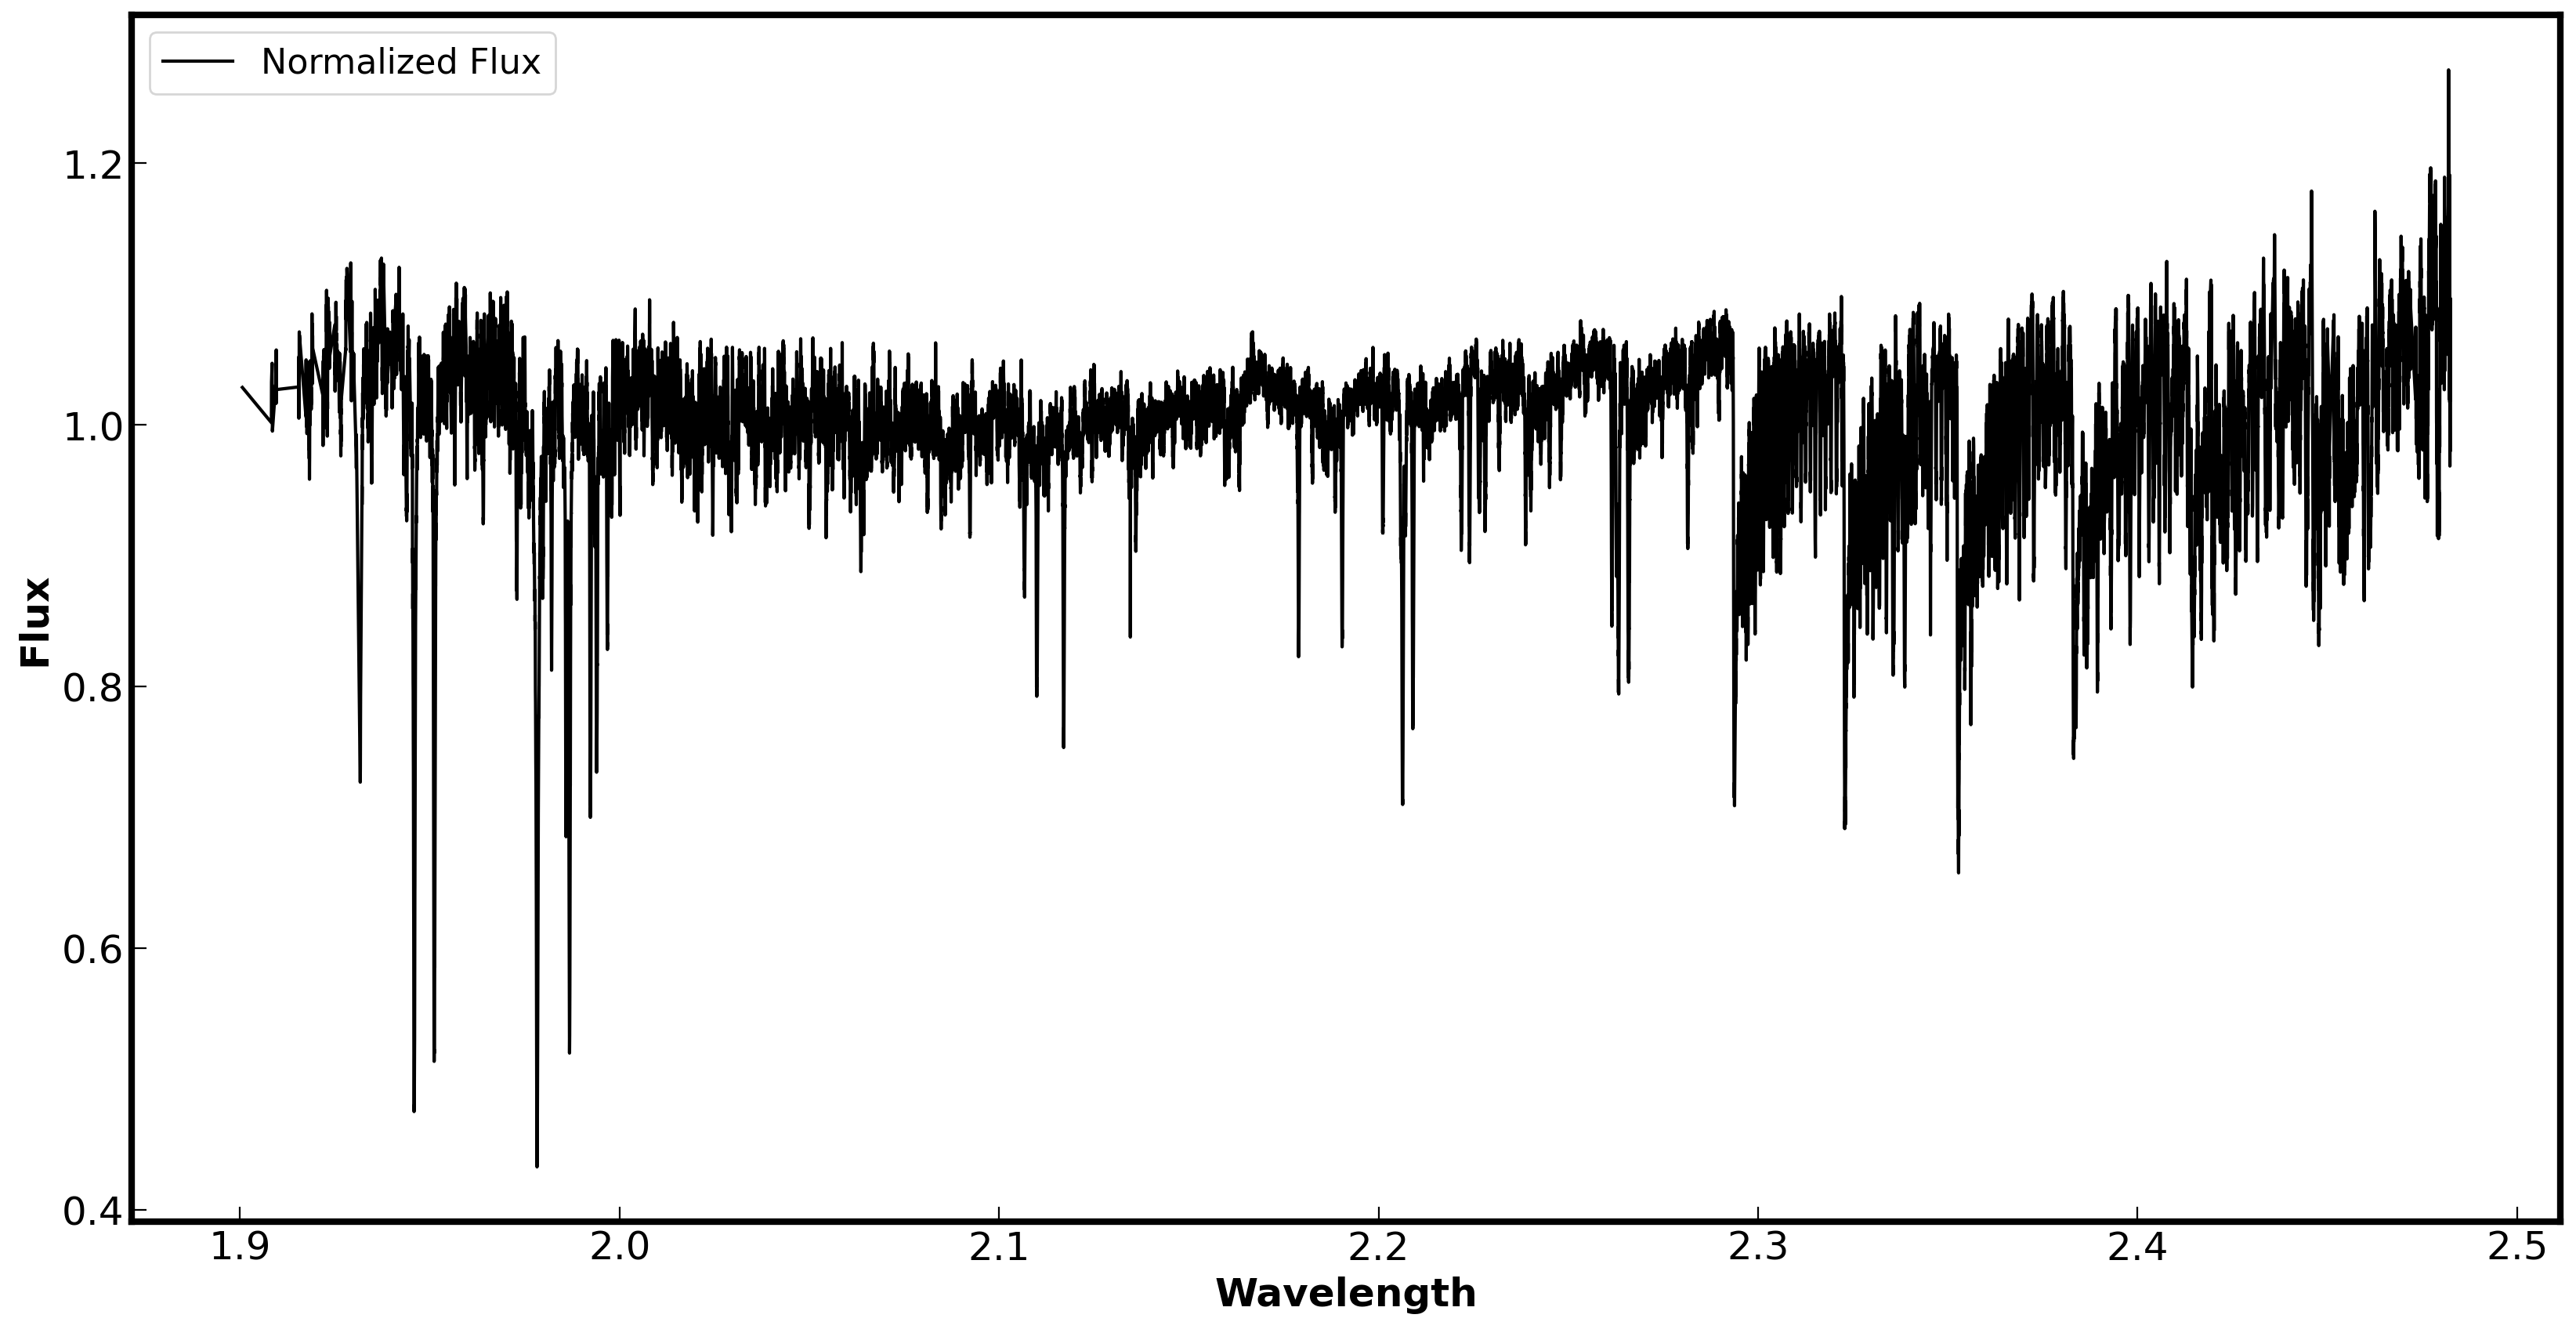

In [57]:
# Make 1D Spectrum Object
anon1_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_flux.values*u.ct)

fig,ax = plt.subplots(figsize=(20,10))

plt.plot(anon1_spec.spectral_axis, (anon1_spec.flux/continuum_fitted),c='black',label='Normalized Flux')
# plt.plot(anon1_spec.spectral_axis,continuum_fitted,label='Continuum')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.legend()
plt.show()

In [35]:
anon1_norm_spec = Spectrum1D(spectral_axis=anon1_spec.spectral_axis[region_mask], flux=anon1_norm_flux[region_mask]*u.ct)

In [54]:
# Spectral Region
# sr = SpectralRegion(2.22*u.um,2.235*u.um)
sr = SpectralRegion(2.2216*u.um,2.2221*u.um)
# Equivalent Width
ew = equivalent_width(anon1_spec,regions=sr)
ew

<Quantity -422.68645245 um>

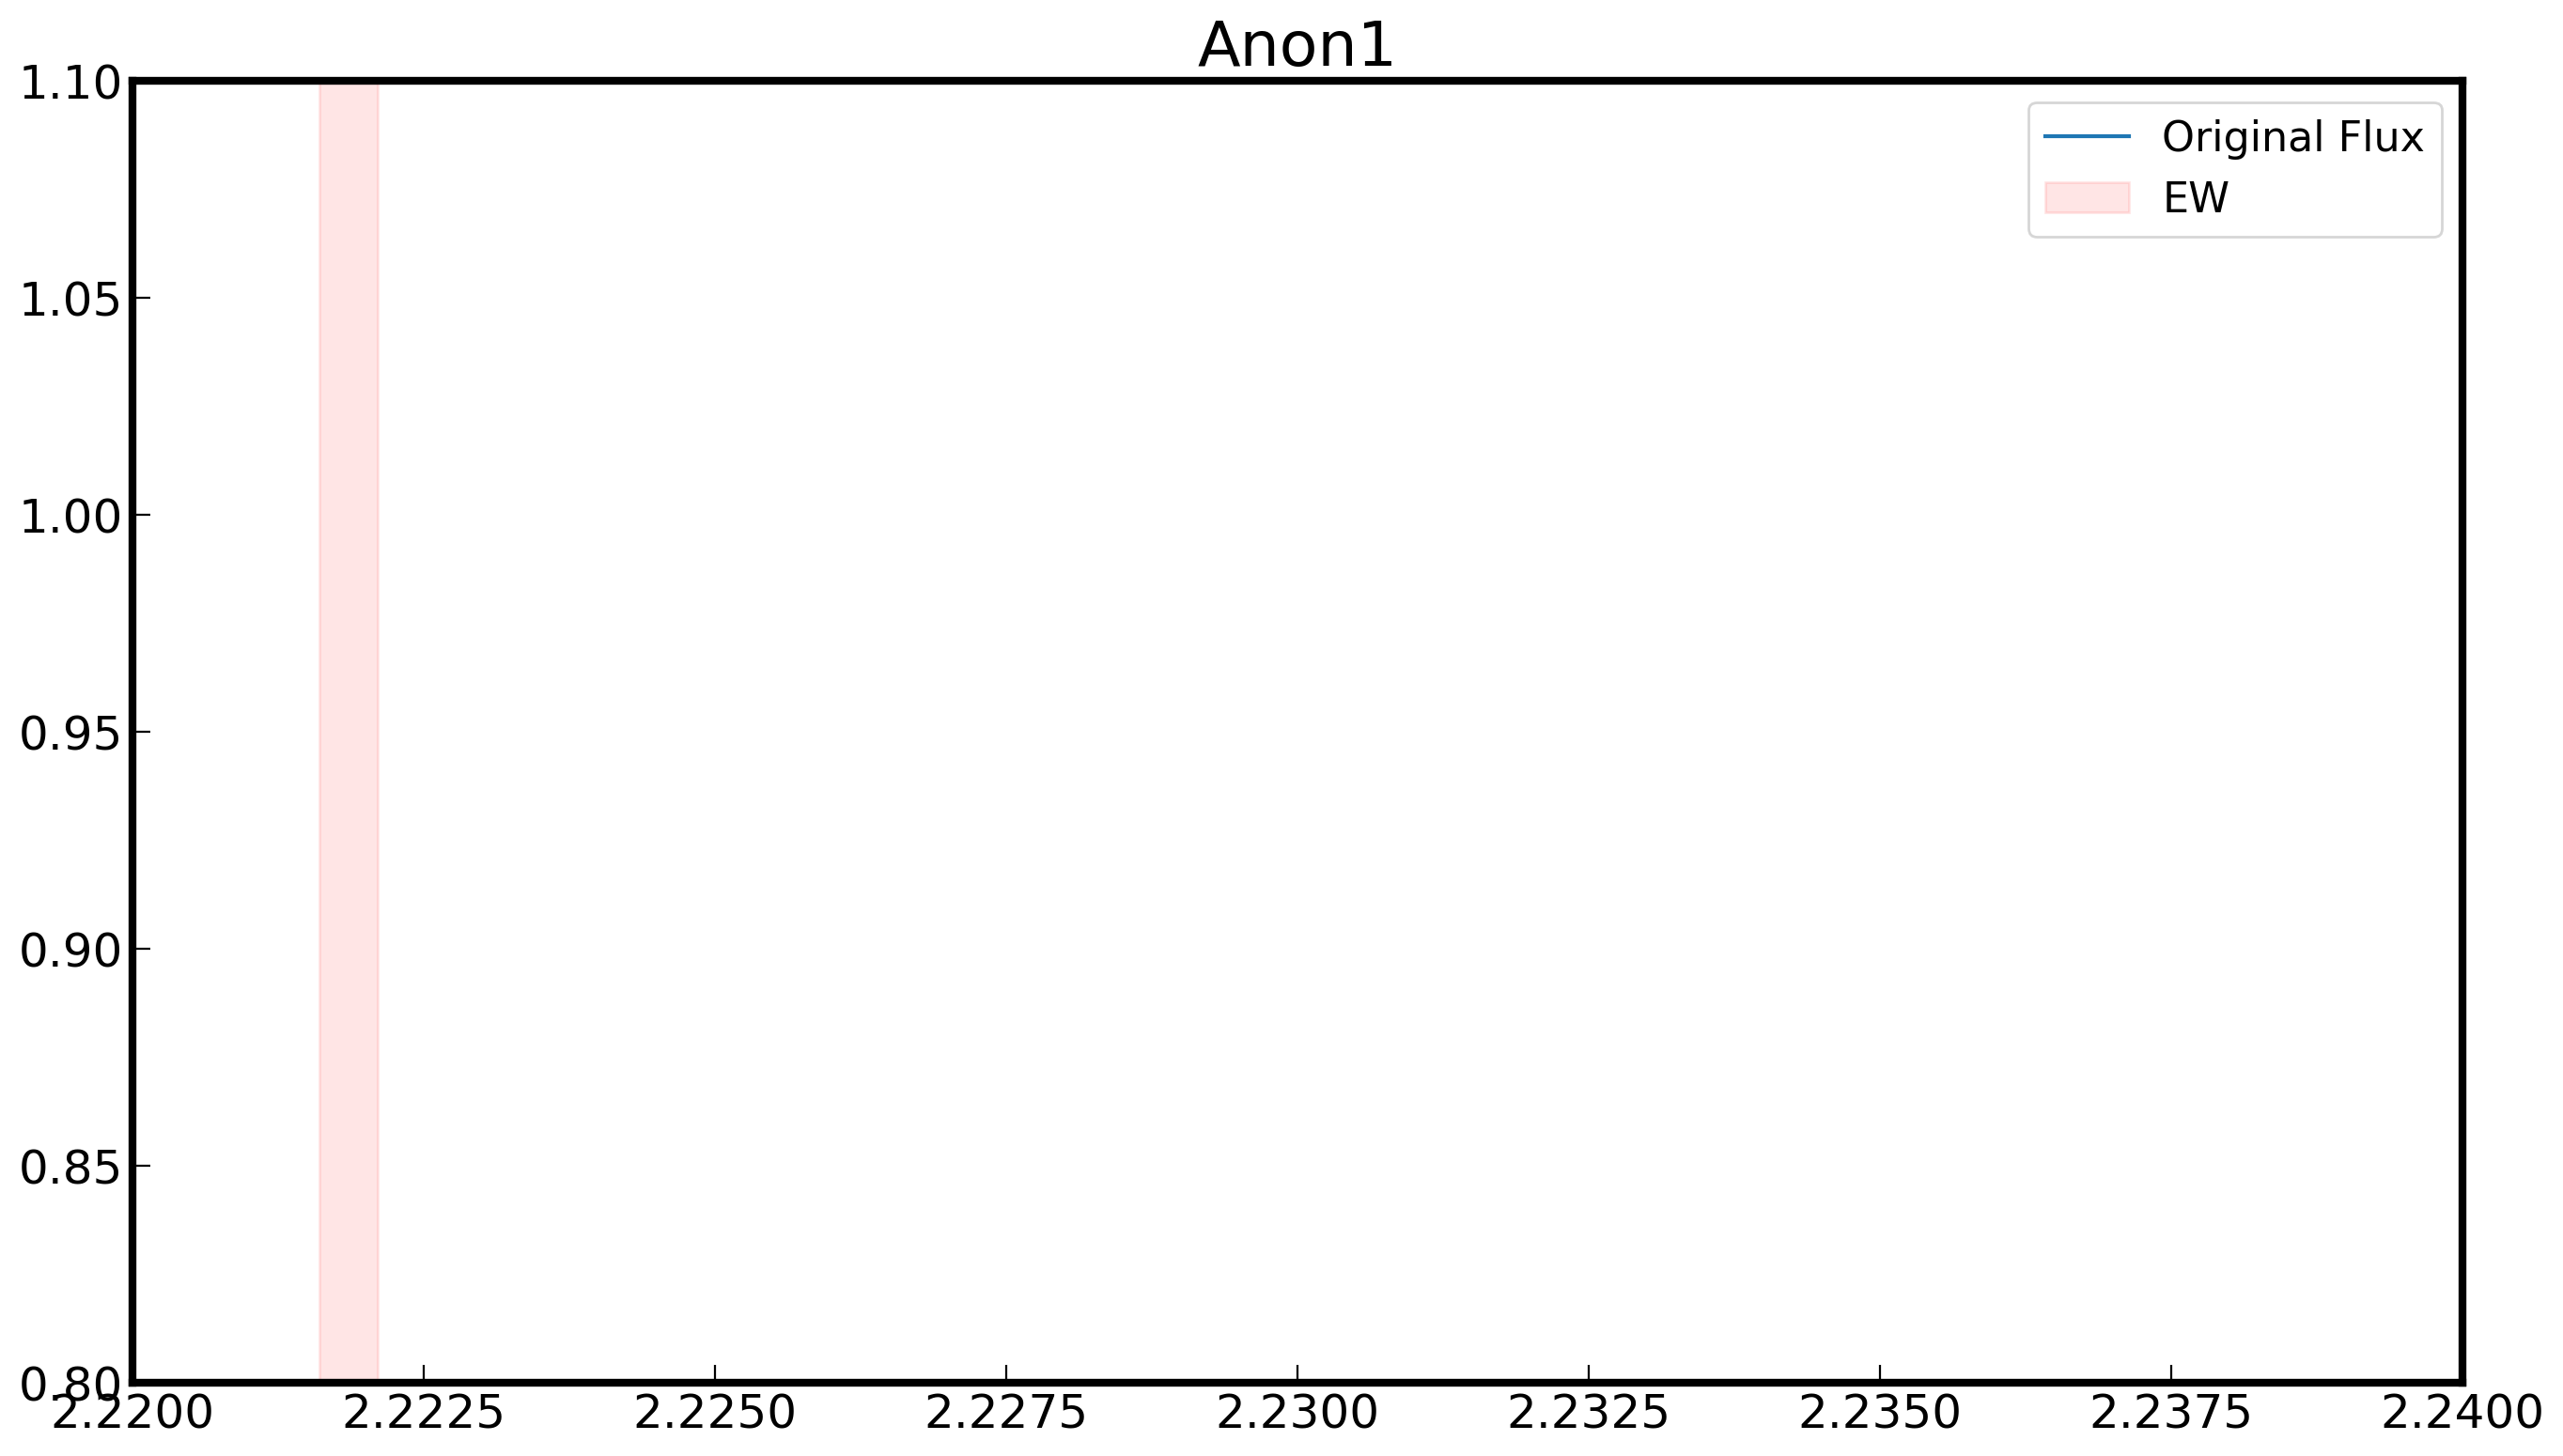

In [55]:
anon1_norm_spec = Spectrum1D(spectral_axis=anon1_wavlen.values*u.um,flux=anon1_norm_flux)
norm_cont = continuum_fitted/continuum_fitted.max()*u.ct

fig,ax = plt.subplots(figsize=(16,9)) 

ax.plot(anon1_spec.spectral_axis,anon1_spec.flux,label='Original Flux')
# ax.plot(anon1_spec.spectral_axis[region_mask],anon1_norm_flux,label='Normalized Flux')
# ax.plot(anon1_norm_spec.spectral_axis,anon1_norm_spec.flux,label='Normalized Flux')
ax.plot(anon1_spec.spectral_axis[region_mask],cont[region_mask],label='Continuum')

# Draw the Equivalent Width box for my amusement
ax.axvspan(2.2216,2.2221,alpha=0.1,color='red',label='EW')

# plt.text(x_position, y_position, f"Equivalent Width: {eq_width.value:.2f} {eq_width.unit}", fontsize=12)
# ax.text(2.2216,2.2221,f"Equivalent Width: {ew.value:.2f}{ew.unit}")

ax.set_xlim(2.22,2.24)
ax.set_ylim(0.8,1.1)
ax.set_title('Anon1')
ax.legend()
plt.show()